In [ ]:
#### IMPORT LIBS AND DEFINE FUNCTIONS #####

import pandas as pd
import numpy as np
import re
import os
import subprocess

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pickle

# Setup Pysembl
from pyensembl import EnsemblRelease
data = EnsemblRelease(106) # Loads release 106 for GRCH38

import pyBigWig
import Bio
from Bio.Seq import Seq

from scipy.stats import fisher_exact
import statsmodels.api as sm

def rev_comp(seq):
    five_prime = Seq(seq)
    rc = str(five_prime.reverse_complement())
    return rc

def get_target1(guide_string):
    temp = guide_string.split("|")
    return temp[0]

def get_target2(guide_string):
    temp = guide_string.split("|")
    if len(temp)>1:
        return temp[-1]
    else:
        return np.NAN

def get_markers(cols, suffix, df, window = 75, files = [], p_val_dict = {}):

    for bw in files:
        base_name = bw.split("/")[-1].split("_")[1] + suffix
        print(base_name)
        peak_pvals = {}

        ## LOAD BIGWIG
        bw = pyBigWig.open(bw)

        ## LOOP THROUGH GUIDES
        for i in range(df.shape[0]):
            row = df.iloc[i]
            name = row.cell_barcode #row["Guide"+suffix]
            chromo = row[cols[0]]
            start = row[cols[1]]
            # if not np.isnan(start):
            if str(chromo) != "nan":
                mean_p = bw.stats(chromo, int(start-window), int(start+window), type='mean', nBins=1)[0]
            else:
                mean_p = np.NAN
            peak_pvals[name] = mean_p

        p_val_dict[base_name] = peak_pvals
        bw.close()

    print(p_val_dict.keys())

    return p_val_dict

def fisher_qc_graph(col, pos_class, df):
    ## SETUP CONTINGENCY TABLE
    marker = str(col[0].split("_")[0])

    # DROP NON-TARGETING (NTC's have Strand NAN's)
    df.dropna(subset=[col], inplace=True)

    # ANEUPLOIDY LABEL
    df["Aneuploidy_OnTarget"] = 0

    # IF targeted-chromo == lost-chromo
    df.loc[df.apply(lambda x: str(x.target_chrom) in str(x.lost_chroms), axis=1),
                 "Aneuploidy_OnTarget"] = 1

    # ANY ANEUPLOIDY: # df.loc[df.apply(lambda x: len(x.lost_chroms)>=1, axis=1), "Aneuploidy_OnTarget"] = 1

    # TABULUTE
    one_hot = df[col].apply(lambda x : 1 if (x >= pos_class) else 0)
    contingency_df = pd.DataFrame({col:one_hot, 'Aneuploidy':list(df.Aneuploidy_OnTarget)})
    table = sm.stats.Table.from_data(contingency_df)
    oddsratio, pvalue = fisher_exact(table.table, alternative='greater')
    pos_pos  = contingency_df.loc[(contingency_df[col] == 1) & (contingency_df.Aneuploidy == 1)].shape[0]
    pos_not = contingency_df.loc[(contingency_df[col] == 1) & (contingency_df.Aneuploidy == 0)].shape[0]
    neg_pos = contingency_df.loc[(contingency_df[col] == 0) & (contingency_df.Aneuploidy == 1)].shape[0]
    neg_not = contingency_df.loc[(contingency_df[col] == 0) & (contingency_df.Aneuploidy == 0)].shape[0]

    # PRINT OUT
    print("# Num " + str(pos_class) + " and Aneuploid: ", pos_pos)
    print("# Num " + str(pos_class) + " and NO Aneuploidy: ", pos_not)
    print("# Num NOT " + str(pos_class) + " and Aneuploid: ", neg_pos)
    print("# Num NOT " + str(pos_class) + " and NO Aneuploidy: ", neg_not)
    print("\n", table.table)
    print(f'\nOddsratio: {oddsratio} \nP-Val: {pvalue}')
    print("Positive-Class and True (%): ", pos_pos/(pos_pos + pos_not) * 100)
    print("Negative-Class and True (%): ", neg_pos/(neg_pos + neg_not) * 100)

    ## GRAPH

    #PLOT
    ax = sns.countplot(x=col, hue="Aneuploidy", data=contingency_df)

    # FORMART
    ax.set_xticklabels(labels = ["Not_" + str(pos_class), str(pos_class)])
    ax.set_title("Aneuploidy by Chromatin Marker" + marker, size = 20)
    ax.set_ylabel("Number of Cells", size = 14)
    ax.set_xlabel(col, size = 14)
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', bottom=False)

    plt.show()

    return [oddsratio, pvalue, table.table, contingency_df]


def fisher_qc_graph_top2_guides(col, pos_class, df, threshold = -np.log10(10**-5)):
    ## SETUP CONTINGENCY TABLE
    marker = str(col[0].split("_")[0])
    print("#### MARKER: ", marker)

    # ANEUPLOIDY LABEL:
    df["Aneuploidy_OnTarget_1"] = 0
    # Dominant Guide: IF targeted-chromo == lost-chromo
    df.loc[df.apply(lambda x: str(x.target_chrom) in str(x.lost_chroms), axis=1),
                 "Aneuploidy_OnTarget_1"] = 1
    # Second Guide: If targeted-chromo == lost-chromo
    has_second_guide = df.loc[~df.Guide_2.isnull()]
    has_second_guide["Aneuploidy_OnTarget_2"] = 0
    has_second_guide.loc[has_second_guide.apply(lambda x: str(x.Target_Chromo_2) in str(x.lost_chroms), axis=1),
                 "Aneuploidy_OnTarget_2"] = 1

    # TABULUTE
    temp1 = list(df[col[0]]) + list(has_second_guide[col[1]])
    one_hot = [0 if x < threshold else 1 for x in temp1]

    temp2 = list(df.Aneuploidy_OnTarget_1) + list(has_second_guide.Aneuploidy_OnTarget_2)
    contingency_df = pd.DataFrame({marker:one_hot, 'Aneuploidy':temp2})

    # DROP NON-TARGETING
    #contingency_df.dropna(subset=marker, inplace=True)

    table = sm.stats.Table.from_data(contingency_df)
    oddsratio, pvalue = fisher_exact(table.table, alternative='greater')
    pos_pos  = contingency_df.loc[(contingency_df[marker] == 1) & (contingency_df.Aneuploidy == 1)].shape[0]
    pos_not = contingency_df.loc[(contingency_df[marker] == 1) & (contingency_df.Aneuploidy == 0)].shape[0]
    neg_pos = contingency_df.loc[(contingency_df[marker] == 0) & (contingency_df.Aneuploidy == 1)].shape[0]
    neg_not = contingency_df.loc[(contingency_df[marker] == 0) & (contingency_df.Aneuploidy == 0)].shape[0]

    # PRINT
    print("# Num " + str(pos_class) + " and Aneuploid: ", pos_pos)
    print("# Num " + str(pos_class) + " and NO Aneuploidy: ", pos_not)
    print("# Num NOT " + str(pos_class) + " and Aneuploid: ", neg_pos)
    print("# Num NOT " + str(pos_class) + " and NO Aneuploidy: ", neg_not)
    print("\n",table.table)
    print(f'\nOddsratio: {oddsratio} \nP-Val: {pvalue}')
    pos_class_true = pos_pos/(pos_pos + pos_not) * 100
    neg_class_true = neg_pos/(neg_pos + neg_not) * 100
    print("Positive-Class and True (%): ", pos_class_true)
    print("Negative-Class and True (%): ", neg_class_true)

    ## GRAPH

    #PLOT
    ax = sns.countplot(x=marker, hue="Aneuploidy", data=contingency_df)

    # FORMART
    ax.set_xticklabels(labels = ["Not_" + str(pos_class), str(pos_class)])
    ax.set_title("Aneuploidy by Chromatin Marker: " + marker, size = 20)
    ax.set_ylabel("Number of Cells", size = 14)
    ax.set_xlabel(col, size = 14)
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', bottom=False)

    plt.show()

    return [pos_class_true, neg_class_true, oddsratio, pvalue, contingency_df, table.table]

In [ ]:
#### GET ANEUPLOIDY DATA ####
all_chromo = "../Supplemental_Data/All_Aneuploidy_Events_ByChromoAndDominantGuide.xlsx"
all_chromos = pd.read_excel(all_chromo)
all_chromos.head(10)

,Guide,Target_Chromo,chr1_no_loss,chr1_lost_partial,chr1_lost_all,chr2_no_loss,chr2_lost_partial,chr2_lost_all,chr3_no_loss,chr3_lost_partial,...,chr19_lost_all,chr20_no_loss,chr20_lost_partial,chr20_lost_all,chr21_no_loss,chr21_lost_partial,chr21_lost_all,chr22_no_loss,chr22_lost_partial,chr22_lost_all
0,ABL1-1,chr9,14,0,0,14,0,0,14,0,...,0,14,0,0,14,0,0,14,0,0
1,ABL1-2,chr9,22,0,0,22,0,0,22,0,...,0,22,0,0,21,0,1,21,1,0
2,ABL1-3,chr9,34,0,0,34,0,0,34,0,...,0,34,0,0,33,0,1,34,0,0
3,ABL1-4,chr9,34,0,0,34,0,0,33,1,...,0,34,0,0,33,0,1,34,0,0
4,ADA2-1,chr22,2008,21,0,2009,17,3,2019,7,...,17,2026,1,2,2000,0,29,1936,43,50
5,ADA2-2,chr22,27,1,0,28,0,0,28,0,...,0,28,0,0,28,0,0,27,0,1
6,ADA2-3,chr22,181,1,0,182,0,0,181,1,...,2,182,0,0,180,0,2,178,4,0
7,ADA2-4,chr22,10,0,0,10,0,0,10,0,...,0,10,0,0,10,0,0,9,1,0
8,ADA-1,chr20,37,0,0,37,0,0,37,0,...,0,34,2,1,37,0,0,37,0,0
9,ADA-2,chr20,663,3,0,659,7,0,659,7,...,3,658,3,5,653,0,13,660,6,0


In [ ]:
#### GET GUIDE DATA ####
genome_coords = pd.read_excel("../Supplemental_Data/Guide_Genomic_Coordinates.xlsx")
genome_coords.head()

,gRNA_ID,Gene,Target_Chromo,Start,Stop,Strand
0,PTPRC-1,PTPRC,chr1,198696890,198696871,Reverse
1,PTPRC-2,PTPRC,chr1,198706756,198706775,Forward
2,PTPRC-3,PTPRC,chr1,198639285,198639266,Reverse
3,PTPRC-4,PTPRC,chr1,198639277,198639296,Forward
4,PIK3CD-1,PIK3CD,chr1,9710417,9710436,Forward


In [ ]:
#### COMBINE ANEUPLODY AND GUIDE COORDS ####
aneu_all_chromos = pd.merge(genome_coords, all_chromos, left_on="gRNA_ID", right_on= "Guide",
                            suffixes=["_GenomeCoords", "_AneuData"])
aneu_all_chromos.head()

,gRNA_ID,Gene,Target_Chromo_GenomeCoords,Start,Stop,Strand,Guide,Target_Chromo_AneuData,chr1_no_loss,chr1_lost_partial,...,chr19_lost_all,chr20_no_loss,chr20_lost_partial,chr20_lost_all,chr21_no_loss,chr21_lost_partial,chr21_lost_all,chr22_no_loss,chr22_lost_partial,chr22_lost_all
0,PTPRC-1,PTPRC,chr1,198696890,198696871,Reverse,PTPRC-1,chr1,21,1,...,0,22,0,0,21,0,1,22,0,0
1,PTPRC-2,PTPRC,chr1,198706756,198706775,Forward,PTPRC-2,chr1,20,1,...,0,21,0,0,21,0,0,21,0,0
2,PTPRC-3,PTPRC,chr1,198639285,198639266,Reverse,PTPRC-3,chr1,9,0,...,0,9,0,0,9,0,0,9,0,0
3,PTPRC-4,PTPRC,chr1,198639277,198639296,Forward,PTPRC-4,chr1,11,0,...,0,11,0,0,11,0,0,11,0,0
4,PIK3CD-1,PIK3CD,chr1,9710417,9710436,Forward,PIK3CD-1,chr1,4,0,...,0,4,0,0,4,0,0,4,0,0


In [ ]:
#### COLLECT GUIDE P-VALUES ####

## PATHS TO ENCODE DATA
bw_path = "../Supplemental_Data/Stimulated_TCell_Data"
bws = [bw_path + x for x in os.listdir(bw_path) if x.endswith(".bigWig")]

## GET PEAK DATA
p_val_dict = {} # Dict for all Markers
markers = []

for bw in bws: # For each bigwig file
    print(bw)
    data = pyBigWig.open(bw) # Open bigwig
    peak_pvals = {} # Dict for Marker_X

    marker = bw.split("/")[-1].split("_")[1]
    print(marker)

    for row in genome_coords.itertuples(): # For each guide
        name = row.gRNA_ID
        chromo = row.Target_Chromo
        start = row.Start
        stop = row.Stop

        # GET P-VALUE AT GUIDE LOCATION
        if str(chromo) != "nan":
            if start < stop:
                mean_p = data.stats(chromo, int(start), int(stop), type='mean', nBins=1)[0]
            elif stop < start:
                mean_p = data.stats(chromo, int(stop), int(start), type='mean', nBins=1)[0]
        else:
            mean_p = np.NAN
        peak_pvals[name] = mean_p

    p_val_dict[marker] = peak_pvals
    markers.append(marker)
    data.close() # Close bigwig

## CONSOLIDATE PEAK DATA
dfs = []
for k,v in p_val_dict.items():
    print(k)
    df = pd.DataFrame({"Guide":v.keys(),"P_Value":v.values()}).sort_values(by="Guide").set_index("Guide").add_suffix(f"_{k}")
    dfs.append(df)

peak_df = pd.concat(dfs, axis = 1)


/Users/marenatrinidad/Code/CROPseq_QC_Connor/Stimulated_TCell_Data/ENCFF233TXT_ATAC_StimTCell.bigWig
ATAC
/Users/marenatrinidad/Code/CROPseq_QC_Connor/Stimulated_TCell_Data/ENCFF793LJI_H3K4me3_ChIPseq_StimTCell.bigWig
H3K4me3
/Users/marenatrinidad/Code/CROPseq_QC_Connor/Stimulated_TCell_Data/ENCFF055FYI_H3K36me3_ChIPseq_StimTCell.bigWig
H3K36me3
/Users/marenatrinidad/Code/CROPseq_QC_Connor/Stimulated_TCell_Data/ENCFF129GAM_H3K9me3_ChIPseq_StimTCell.bigWig
H3K9me3
/Users/marenatrinidad/Code/CROPseq_QC_Connor/Stimulated_TCell_Data/ENCFF183DBM_H3K4me1_ChIPseq_StimTCell.bigWig
H3K4me1
/Users/marenatrinidad/Code/CROPseq_QC_Connor/Stimulated_TCell_Data/ENCFF388LNF_H3K27Ac_ChIPseq_StimTCell.bigWig
H3K27Ac
/Users/marenatrinidad/Code/CROPseq_QC_Connor/Stimulated_TCell_Data/ENCFF468VXI_H3K27me3_ChIPseq_StimTCell.bigWig
H3K27me3
ATAC
H3K4me3
H3K36me3
H3K9me3
H3K4me1
H3K27Ac
H3K27me3


In [ ]:
peak_df.head()

,P_Value_ATAC,P_Value_H3K4me3,P_Value_H3K36me3,P_Value_H3K9me3,P_Value_H3K4me1,P_Value_H3K27Ac,P_Value_H3K27me3
Guide,,,,,,,
ABL1-1,0.017530,0.000777,0.051970,0.006610,0.347737,0.120110,0.016640
ABL1-2,0.711400,0.000000,1.528975,0.000109,0.009804,0.000176,0.009740
ABL1-3,0.005550,0.001658,11.748565,0.002088,1.395266,0.232616,0.016640
ABL1-4,0.005550,0.001180,0.249398,0.008060,0.028340,0.009990,0.001681
ADA-1,0.131591,0.001178,1.515979,0.118297,1.208392,0.137495,0.016640


In [ ]:
#### TABULATE LOSSES BY MARKER ####
no_loss_cols = [x for x in aneu_all_chromos.columns if "_no_loss" in x]
loss_cols = [x for x in aneu_all_chromos.columns if ("lost" in x)]
marker_aneu_dict = {}

for marker in markers:# For each marker
    marker_col = f"P_Value_{marker}"
    rows = []

    for row in peak_df.itertuples(): # For all guides
        guide = row.Index
        #print(guide)

        no_loss = aneu_all_chromos.loc[aneu_all_chromos.gRNA_ID == guide][no_loss_cols].sum().sum()
        loss = aneu_all_chromos.loc[aneu_all_chromos.gRNA_ID == guide][loss_cols].sum().sum()
        row = [guide, loss, no_loss]
        rows.append(row)

    marker_df = pd.DataFrame(rows, columns=["Guide", "Loss", "No_Loss"]).sort_values(by="Guide").set_index("Guide").add_prefix(f"{marker}_")
    marker_aneu_dict[marker] = marker_df

# CONSOLIDATE INTO SINGLE DF
dfs = []
for k,v in marker_aneu_dict.items():
    dfs.append(v)

aneuploidy_count_df = pd.concat(dfs, axis = 1)

aneuploidy_count_df.head()

,ATAC_Loss,ATAC_No_Loss,H3K4me3_Loss,H3K4me3_No_Loss,H3K36me3_Loss,H3K36me3_No_Loss,H3K9me3_Loss,H3K9me3_No_Loss,H3K4me1_Loss,H3K4me1_No_Loss,H3K27Ac_Loss,H3K27Ac_No_Loss,H3K27me3_Loss,H3K27me3_No_Loss
Guide,,,,,,,,,,,,,,
ABL1-1,3.0,305.0,3.0,305.0,3.0,305.0,3.0,305.0,3.0,305.0,3.0,305.0,3.0,305.0
ABL1-2,3.0,481.0,3.0,481.0,3.0,481.0,3.0,481.0,3.0,481.0,3.0,481.0,3.0,481.0
ABL1-3,6.0,742.0,6.0,742.0,6.0,742.0,6.0,742.0,6.0,742.0,6.0,742.0,6.0,742.0
ABL1-4,14.0,734.0,14.0,734.0,14.0,734.0,14.0,734.0,14.0,734.0,14.0,734.0,14.0,734.0
ADA-1,5.0,809.0,5.0,809.0,5.0,809.0,5.0,809.0,5.0,809.0,5.0,809.0,5.0,809.0


In [ ]:
## CONCAT DATA
aneu_summary = pd.concat([peak_df, aneuploidy_count_df], axis = 1)

aneu_summary.head()

5.0


,P_Value_ATAC,P_Value_H3K4me3,P_Value_H3K36me3,P_Value_H3K9me3,P_Value_H3K4me1,P_Value_H3K27Ac,P_Value_H3K27me3,ATAC_Loss,ATAC_No_Loss,H3K4me3_Loss,...,H3K36me3_Loss,H3K36me3_No_Loss,H3K9me3_Loss,H3K9me3_No_Loss,H3K4me1_Loss,H3K4me1_No_Loss,H3K27Ac_Loss,H3K27Ac_No_Loss,H3K27me3_Loss,H3K27me3_No_Loss
Guide,,,,,,,,,,,,,,,,,,,,,
ABL1-1,0.017530,0.000777,0.051970,0.006610,0.347737,0.120110,0.016640,3.0,305.0,3.0,...,3.0,305.0,3.0,305.0,3.0,305.0,3.0,305.0,3.0,305.0
ABL1-2,0.711400,0.000000,1.528975,0.000109,0.009804,0.000176,0.009740,3.0,481.0,3.0,...,3.0,481.0,3.0,481.0,3.0,481.0,3.0,481.0,3.0,481.0
ABL1-3,0.005550,0.001658,11.748565,0.002088,1.395266,0.232616,0.016640,6.0,742.0,6.0,...,6.0,742.0,6.0,742.0,6.0,742.0,6.0,742.0,6.0,742.0
ABL1-4,0.005550,0.001180,0.249398,0.008060,0.028340,0.009990,0.001681,14.0,734.0,14.0,...,14.0,734.0,14.0,734.0,14.0,734.0,14.0,734.0,14.0,734.0
ADA-1,0.131591,0.001178,1.515979,0.118297,1.208392,0.137495,0.016640,5.0,809.0,5.0,...,5.0,809.0,5.0,809.0,5.0,809.0,5.0,809.0,5.0,809.0


In [ ]:
#### EPIGENETIC ANALYSIS: PAM on Prox or Distal arm ####
# Num cells: 1,209,516

# READ p/q ARM DATA FOR GUIDES
arm_data = pd.read_excel("../Supplemental_Data/Guide_Metadata.xlsx")
arm_data = arm_data[["Gene", "gRNA #", "Arm"]]
arm_data["gRNA_ID"] = arm_data["Gene"] + "-" + arm_data["gRNA #"].apply(lambda x: str(x)[0])

merged = pd.merge(aneu_all_chromos, arm_data[["gRNA_ID", "Arm"]], how= "left", on = "gRNA_ID")
merged["PAM_Prox_Distal"] = np.NAN
merged.loc[((merged.Strand == "Forward") & (merged.Arm == "p")) |
           ((merged.Strand == "Reverse") & (merged.Arm == "q")), "PAM_Prox_Distal"] = "Proximal"
merged.loc[((merged.Strand == "Reverse") & (merged.Arm == "p")) |
           ((merged.Strand == "Forward") & (merged.Arm == "q")), "PAM_Prox_Distal"] = "Distal"

rows = []

marker = "PAM_Prox_Distal"
slice_cols = [f"{marker}_Loss", f"{marker}_No_Loss"]

forward_aneu = merged.loc[merged.PAM_Prox_Distal == "Proximal"][loss_cols].sum().sum()
forward_no_aneu = merged.loc[merged.PAM_Prox_Distal == "Proximal"][no_loss_cols].sum().sum()

reverse_aneu = merged.loc[merged.PAM_Prox_Distal == "Distal"][loss_cols].sum().sum()
reverse_no_aneu = merged.loc[merged.PAM_Prox_Distal == "Distal"][no_loss_cols].sum().sum()

contingency = np.array([[reverse_no_aneu, reverse_aneu],[forward_no_aneu, forward_aneu]])
oddsr, pval = fisher_exact(contingency, alternative = 'two-sided')

row = [marker, oddsr, pval, 'two-sided',
       reverse_no_aneu, reverse_aneu, forward_no_aneu, forward_aneu]
rows.append(row)

fisher_df2 = pd.DataFrame(rows, columns = ["Marker", "Odds_Ratio", "P_Val", "Test_Sidedness",
                                          "Num_Distal_No_Aneuploidy", "Num_Distal_Is_Aneuploid",
                                          "Num_Proximal_No_Aneuploid", "Num_Proximal_Is_Aneuploid"])

# Verify Cell Count:
f_cols = fisher_df2.columns
print("N Cells:", fisher_df2[f_cols[3:]].sum(axis = 1))

fisher_df2["Percent_Distal_With_Aneuploidy"] = fisher_df2.Num_Distal_Is_Aneuploid / (fisher_df2.Num_Distal_Is_Aneuploid + fisher_df2.Num_Distal_No_Aneuploidy) * 100
fisher_df2["Percent_Proximal_With_Aneuploidy"] = fisher_df2.Num_Proximal_Is_Aneuploid / (fisher_df2.Num_Proximal_Is_Aneuploid + fisher_df2.Num_Proximal_No_Aneuploid) * 100

fisher_df2

N Cells: 0    1138874
dtype: int64


/var/folders/7j/kmnyk4vx06nbh6fwj_sf7_nh0000gn/T/ipykernel_94606/957790978.py:39: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print("N Cells:", fisher_df2[f_cols[3:]].sum(axis = 1))


,Marker,Odds_Ratio,P_Val,Test_Sidedness,Num_Distal_No_Aneuploidy,Num_Distal_Is_Aneuploid,Num_Proximal_No_Aneuploid,Num_Proximal_Is_Aneuploid,PAM_Prox_Distal_Percent_Loss_No_Peak,PAM_Prox_Distal_Percent_Loss_With_Peak
0,PAM_Prox_Distal,1.010162,0.592413,two-sided,580080,5868,547333,5593,1.001454,1.011528


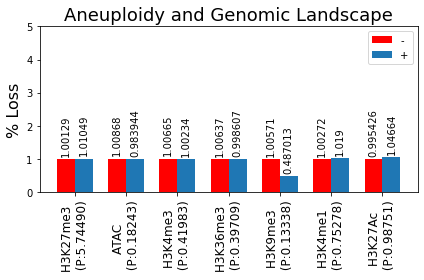

In [ ]:
#### PLOT ####
import matplotlib.pyplot as plt
import numpy as np

pvalues = [list(fisher_df.P_Val)[-1]] + list(fisher_df.P_Val)[:-1]
pvalues = [str(x) for x in pvalues]

labels = [list(fisher_df.Marker)[-1]] + list(fisher_df.Marker)[:-1]
labels = [f"{labels[i]} \n (P:{pvalues[i]:.7})" for i in range(len(labels))]
neg_class = [list(fisher_df.Strand_Percent_Loss_No_Peak)[-1]] + list(fisher_df.Percent_Loss_No_Peak)[:-1]
pos_class = [list(fisher_df.Strand_Percent_Loss_With_Peak)[-1]] + list(fisher_df.Percent_Loss_With_Peak)[:-1]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x = list(x - width/2), height = neg_class, label = "-", width = width, color = 'r')
rects2 = ax.bar(x = list(x + width/2), height = pos_class, label = "+", width = width)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Loss', size=16)
ax.set_title('Aneuploidy and Genomic Landscape', size=18)
ax.set_xticks(x, labels, rotation = 90, size=12)
ax.set_ylim(0,5)
ax.legend()

ax.bar_label(rects1, padding=3, rotation = 90)
ax.bar_label(rects2, padding=3, rotation = 90)

fig.tight_layout()

plt.show()

In [ ]:
#### EPIGENETIC ANALYSIS: Fisher Exact, Greater Than####
# Num cells: 1,209,516

rows = []
marker_sidedness = {'Strand':"greater", 'ATAC':"greater", 'H3K4me3':"greater", 'H3K36me3':"greater",
                    'H3K9me3':"greater", 'H3K4me1':"greater", 'H3K27Ac':"greater", 'H3K27me3':"greater"}
for marker in markers:
    marker_p_val_col = f"P_Value_{marker}"
    slice_cols = [f"{marker}_Loss", f"{marker}_No_Loss"]

    guide_with_peak = aneu_summary.loc[aneu_summary[marker_p_val_col] > threshold][slice_cols].sum().values
    peak_aneu = guide_with_peak[0]
    peak_no_aneu = guide_with_peak[1]

    guide_without_peak = aneu_summary.loc[aneu_summary[marker_p_val_col] < threshold][slice_cols].sum().values
    no_peak_aneu = guide_without_peak[0]
    no_peak_no_aneu = guide_without_peak[1]

    contingency = np.array([[no_peak_no_aneu, no_peak_aneu],[peak_no_aneu, peak_aneu]])
    oddsr, pval = fisher_exact(contingency, alternative = marker_sidedness[marker])

    row = [marker, oddsr, pval, marker_sidedness[marker], no_peak_no_aneu, no_peak_aneu, peak_no_aneu, peak_aneu]
    rows.append(row)

fisher_df1 = pd.DataFrame(rows, columns = ["Marker", "Odds_Ratio", "P_Val", "Test_Sidedness",
                                          "Num_No_Peak_No_Aneuploidy", "Num_No_Peak_Is_Aneuploid",
                                          "Num_Has_Peak_No_Aneuploid", "Num_Has_Peak_Is_Aneuploid"])

fisher_df1["Percent_Loss_No_Peak"] = fisher_df1.Num_No_Peak_Is_Aneuploid / (fisher_df1.Num_No_Peak_Is_Aneuploid + fisher_df1.Num_No_Peak_No_Aneuploidy) * 100
fisher_df1["Percent_Loss_With_Peak"] = fisher_df1.Num_Has_Peak_Is_Aneuploid / (fisher_df1.Num_Has_Peak_Is_Aneuploid + fisher_df1.Num_Has_Peak_No_Aneuploid) * 100

# Verify Cell Count:
#f_cols = fisher_df1.columns
#print("N Cells:", fisher_df1[f_cols[3:]].sum(axis = 1))

fisher_df1

,Marker,Odds_Ratio,P_Val,Test_Sidedness,Num_No_Peak_No_Aneuploidy,Num_No_Peak_Is_Aneuploid,Num_Has_Peak_No_Aneuploid,Num_Has_Peak_Is_Aneuploid,Percent_Loss_No_Peak,Percent_Loss_With_Peak
0,ATAC,0.975229,0.824663,greater,1040470.0,10602.0,156885.0,1559.0,1.008684,0.983944
1,H3K4me3,0.995666,0.588080,greater,861646.0,8762.0,335709.0,3399.0,1.006654,1.002336
2,H3K36me3,0.992204,0.613703,greater,1053801.0,10713.0,143554.0,1448.0,1.006375,0.998607
3,H3K9me3,0.481725,0.946997,greater,1196742.0,12158.0,613.0,3.0,1.005708,0.487013
4,H3K4me1,1.016399,0.254961,greater,997061.0,10099.0,200294.0,2062.0,1.002721,1.018996
5,H3K27Ac,1.051996,0.013241,greater,963265.0,9685.0,234090.0,2476.0,0.995426,1.046642
6,H3K27me3,0.871930,0.999950,greater,1104008.0,11326.0,93347.0,835.0,1.015481,0.886581


In [ ]:
#### EPIGENETIC ANALYSIS:Fisher Exact, Less Than####
# Num cells: 1,209,516

rows = []
marker_sidedness = {'Strand':"less", 'ATAC':"less", 'H3K4me3':"less", 'H3K36me3':"less",
                    'H3K9me3':"less", 'H3K4me1':"less", 'H3K27Ac':"less", 'H3K27me3':"less"}
for marker in markers:
    marker_p_val_col = f"P_Value_{marker}"
    slice_cols = [f"{marker}_Loss", f"{marker}_No_Loss"]

    guide_with_peak = aneu_summary.loc[aneu_summary[marker_p_val_col] > threshold][slice_cols].sum().values
    peak_aneu = guide_with_peak[0]
    peak_no_aneu = guide_with_peak[1]

    guide_without_peak = aneu_summary.loc[aneu_summary[marker_p_val_col] < threshold][slice_cols].sum().values
    no_peak_aneu = guide_without_peak[0]
    no_peak_no_aneu = guide_without_peak[1]

    contingency = np.array([[no_peak_no_aneu, no_peak_aneu],[peak_no_aneu, peak_aneu]])
    oddsr, pval = fisher_exact(contingency, alternative = marker_sidedness[marker])

    row = [marker, oddsr, pval, marker_sidedness[marker], no_peak_no_aneu, no_peak_aneu, peak_no_aneu, peak_aneu]
    rows.append(row)

fisher_df2 = pd.DataFrame(rows, columns = ["Marker", "Odds_Ratio", "P_Val", "Test_Sidedness",
                                          "Num_No_Peak_No_Aneuploidy", "Num_No_Peak_Is_Aneuploid",
                                          "Num_Has_Peak_No_Aneuploid", "Num_Has_Peak_Is_Aneuploid"])

fisher_df2["Percent_Loss_No_Peak"] = fisher_df2.Num_No_Peak_Is_Aneuploid / (fisher_df2.Num_No_Peak_Is_Aneuploid + fisher_df2.Num_No_Peak_No_Aneuploidy) * 100
fisher_df2["Percent_Loss_With_Peak"] = fisher_df2.Num_Has_Peak_Is_Aneuploid / (fisher_df2.Num_Has_Peak_Is_Aneuploid + fisher_df2.Num_Has_Peak_No_Aneuploid) * 100

# Verify Cell Count:
#f_cols = fisher_df2.columns
#print("N Cells:", fisher_df2[f_cols[3:]].sum(axis = 1))

fisher_df2

,Marker,Odds_Ratio,P_Val,Test_Sidedness,Num_No_Peak_No_Aneuploidy,Num_No_Peak_Is_Aneuploid,Num_Has_Peak_No_Aneuploid,Num_Has_Peak_Is_Aneuploid,Percent_Loss_No_Peak,Percent_Loss_With_Peak
0,ATAC,0.975229,0.182440,less,1040470.0,10602.0,156885.0,1559.0,1.008684,0.983944
1,H3K4me3,0.995666,0.419839,less,861646.0,8762.0,335709.0,3399.0,1.006654,1.002336
2,H3K36me3,0.992204,0.397096,less,1053801.0,10713.0,143554.0,1448.0,1.006375,0.998607
3,H3K9me3,0.481725,0.133384,less,1196742.0,12158.0,613.0,3.0,1.005708,0.487013
4,H3K4me1,1.016399,0.752788,less,997061.0,10099.0,200294.0,2062.0,1.002721,1.018996
5,H3K27Ac,1.051996,0.987514,less,963265.0,9685.0,234090.0,2476.0,0.995426,1.046642
6,H3K27me3,0.871930,0.000057,less,1104008.0,11326.0,93347.0,835.0,1.015481,0.886581


In [ ]:
#### EPIGENETIC ANALYSIS: Fisher Exact, two-sided####
# Num cells: 1,209,516

rows = []
marker_sidedness = {'Strand':"two-sided", 'ATAC':"two-sided", 'H3K4me3':"two-sided", 'H3K36me3':"two-sided",
                    'H3K9me3':"two-sided", 'H3K4me1':"two-sided", 'H3K27Ac':"two-sided", 'H3K27me3':"two-sided"}
for marker in markers:
    marker_p_val_col = f"P_Value_{marker}"
    slice_cols = [f"{marker}_Loss", f"{marker}_No_Loss"]

    guide_with_peak = aneu_summary.loc[aneu_summary[marker_p_val_col] > threshold][slice_cols].sum().values
    peak_aneu = guide_with_peak[0]
    peak_no_aneu = guide_with_peak[1]

    guide_without_peak = aneu_summary.loc[aneu_summary[marker_p_val_col] < threshold][slice_cols].sum().values
    no_peak_aneu = guide_without_peak[0]
    no_peak_no_aneu = guide_without_peak[1]

    contingency = np.array([[no_peak_no_aneu, no_peak_aneu],[peak_no_aneu, peak_aneu]])
    oddsr, pval = fisher_exact(contingency, alternative = marker_sidedness[marker])

    row = [marker, oddsr, pval, marker_sidedness[marker], no_peak_no_aneu, no_peak_aneu, peak_no_aneu, peak_aneu]
    rows.append(row)

fisher_df3 = pd.DataFrame(rows, columns = ["Marker", "Odds_Ratio", "P_Val", "Test_Sidedness",
                                          "Num_No_Peak_No_Aneuploidy", "Num_No_Peak_Is_Aneuploid",
                                          "Num_Has_Peak_No_Aneuploid", "Num_Has_Peak_Is_Aneuploid"])

fisher_df3["Percent_Loss_No_Peak"] = fisher_df3.Num_No_Peak_Is_Aneuploid / (fisher_df3.Num_No_Peak_Is_Aneuploid + fisher_df3.Num_No_Peak_No_Aneuploidy) * 100
fisher_df3["Percent_Loss_With_Peak"] = fisher_df3.Num_Has_Peak_Is_Aneuploid / (fisher_df3.Num_Has_Peak_Is_Aneuploid + fisher_df3.Num_Has_Peak_No_Aneuploid) * 100

# Verify Cell Count:
#f_cols = fisher_df3.columns
#print("N Cells:", fisher_df3[f_cols[3:]].sum(axis = 1))

fisher_df3

,Marker,Odds_Ratio,P_Val,Test_Sidedness,Num_No_Peak_No_Aneuploidy,Num_No_Peak_Is_Aneuploid,Num_Has_Peak_No_Aneuploid,Num_Has_Peak_Is_Aneuploid,Percent_Loss_No_Peak,Percent_Loss_With_Peak
0,ATAC,0.975229,0.365496,two-sided,1040470.0,10602.0,156885.0,1559.0,1.008684,0.983944
1,H3K4me3,0.995666,0.839211,two-sided,861646.0,8762.0,335709.0,3399.0,1.006654,1.002336
2,H3K36me3,0.992204,0.789824,two-sided,1053801.0,10713.0,143554.0,1448.0,1.006375,0.998607
3,H3K9me3,0.481725,0.305706,two-sided,1196742.0,12158.0,613.0,3.0,1.005708,0.487013
4,H3K4me1,1.016399,0.501905,two-sided,997061.0,10099.0,200294.0,2062.0,1.002721,1.018996
5,H3K27Ac,1.051996,0.025821,two-sided,963265.0,9685.0,234090.0,2476.0,0.995426,1.046642
6,H3K27me3,0.871930,0.000113,two-sided,1104008.0,11326.0,93347.0,835.0,1.015481,0.886581


In [ ]:
#### STRANDEDNESS: Fisher Exact ####
# Num cells: 1,209,516

rows = []

marker = "Strand"
for h_alt in ["greater", "less", "two-sided"]:
    slice_cols = [f"{marker}_Loss", f"{marker}_No_Loss"]

    forward_aneu = aneu_all_chromos.loc[aneu_all_chromos.Strand == "Forward"][loss_cols].sum().sum()
    forward_no_aneu = aneu_all_chromos.loc[aneu_all_chromos.Strand == "Forward"][no_loss_cols].sum().sum()

    reverse_aneu = aneu_all_chromos.loc[aneu_all_chromos.Strand == "Reverse"][loss_cols].sum().sum()
    reverse_no_aneu = aneu_all_chromos.loc[aneu_all_chromos.Strand == "Reverse"][no_loss_cols].sum().sum()

    contingency = np.array([[reverse_no_aneu, reverse_aneu],[forward_no_aneu, forward_aneu]])
    oddsr, pval = fisher_exact(contingency, alternative=h_alt)

    row = [marker, oddsr, pval, h_alt,
           reverse_no_aneu, reverse_aneu, forward_no_aneu, forward_aneu]
    rows.append(row)

fisher_df4 = pd.DataFrame(rows, columns = ["Marker", "Odds_Ratio", "P_Val", "Test_Sidedness",
                                          "Num_Reverse_No_Aneuploidy", "Num_Reverse_Is_Aneuploid",
                                          "Num_Forward_No_Aneuploid", "Num_Forward_Is_Aneuploid"])

# Verify Cell Count:
f_cols = fisher_df4.columns
print("N Cells:", fisher_df4[f_cols[3:]].sum(axis = 1))

fisher_df4["Strand_Percent_Loss_No_Peak"] = fisher_df4.Num_Reverse_Is_Aneuploid / (fisher_df4.Num_Reverse_Is_Aneuploid + fisher_df4.Num_Reverse_No_Aneuploidy) * 100
fisher_df4["Strand_Percent_Loss_With_Peak"] = fisher_df4.Num_Forward_Is_Aneuploid / (fisher_df4.Num_Forward_Is_Aneuploid + fisher_df4.Num_Forward_No_Aneuploid) * 100

fisher_df4

N Cells: 0    1209516
1    1209516
2    1209516
dtype: int64


/var/folders/7j/kmnyk4vx06nbh6fwj_sf7_nh0000gn/T/ipykernel_8528/931797702.py:29: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print("N Cells:", fisher_df4[f_cols[3:]].sum(axis = 1))


,Marker,Odds_Ratio,P_Val,Test_Sidedness,Num_Reverse_No_Aneuploidy,Num_Reverse_Is_Aneuploid,Num_Forward_No_Aneuploid,Num_Forward_Is_Aneuploid,Strand_Percent_Loss_No_Peak,Strand_Percent_Loss_With_Peak
0,Strand,1.009279,0.310089,greater,656702,6642,540653,5519,1.00129,1.010488
1,Strand,1.009279,0.696342,less,656702,6642,540653,5519,1.00129,1.010488
2,Strand,1.009279,0.614526,two-sided,656702,6642,540653,5519,1.00129,1.010488


In [ ]:
#### COLLECT AND SAVE RESULTS
fisher_df = pd.concat([fisher_df1, fisher_df2, fisher_df3, fisher_df4], axis = 0)
print(fisher_df.shape[0])

#fisher_df.to_excel("Aneuploidy_And_Epigenetic_Marker_Summary.xlsx", index = False)
fisher_df.head(25)

24


,Marker,Odds_Ratio,P_Val,Test_Sidedness,Num_No_Peak_No_Aneuploidy,Num_No_Peak_Is_Aneuploid,Num_Has_Peak_No_Aneuploid,Num_Has_Peak_Is_Aneuploid,Percent_Loss_No_Peak,Percent_Loss_With_Peak,Num_Reverse_No_Aneuploidy,Num_Reverse_Is_Aneuploid,Num_Forward_No_Aneuploid,Num_Forward_Is_Aneuploid,Strand_Percent_Loss_No_Peak,Strand_Percent_Loss_With_Peak
0,ATAC,0.975229,0.824663,greater,1040470.0,10602.0,156885.0,1559.0,1.008684,0.983944,NaN,NaN,NaN,NaN,NaN,NaN
1,H3K4me3,0.995666,0.588080,greater,861646.0,8762.0,335709.0,3399.0,1.006654,1.002336,NaN,NaN,NaN,NaN,NaN,NaN
2,H3K36me3,0.992204,0.613703,greater,1053801.0,10713.0,143554.0,1448.0,1.006375,0.998607,NaN,NaN,NaN,NaN,NaN,NaN
3,H3K9me3,0.481725,0.946997,greater,1196742.0,12158.0,613.0,3.0,1.005708,0.487013,NaN,NaN,NaN,NaN,NaN,NaN
4,H3K4me1,1.016399,0.254961,greater,997061.0,10099.0,200294.0,2062.0,1.002721,1.018996,NaN,NaN,NaN,NaN,NaN,NaN
5,H3K27Ac,1.051996,0.013241,greater,963265.0,9685.0,234090.0,2476.0,0.995426,1.046642,NaN,NaN,NaN,NaN,NaN,NaN
6,H3K27me3,0.871930,0.999950,greater,1104008.0,11326.0,93347.0,835.0,1.015481,0.886581,NaN,NaN,NaN,NaN,NaN,NaN
0,ATAC,0.975229,0.182440,less,1040470.0,10602.0,156885.0,1559.0,1.008684,0.983944,NaN,NaN,NaN,NaN,NaN,NaN
1,H3K4me3,0.995666,0.419839,less,861646.0,8762.0,335709.0,3399.0,1.006654,1.002336,NaN,NaN,NaN,NaN,NaN,NaN
2,H3K36me3,0.992204,0.397096,less,1053801.0,10713.0,143554.0,1448.0,1.006375,0.998607,NaN,NaN,NaN,NaN,NaN,NaN
